### Control Parameters 

In [1]:
import datetime
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load

In [2]:
## parameters
exp_index = [
            'coil',
            'double_coil',
            'reverse_coil',
            'reverse_double_coil',
            'down_coil',
            'reverse_down_coil',
            'square',
            'double_square',
            'lines',
            'lines2',
            'reverse_lines',
            'reverse_lines2',
            'manual',
#             'manual_wind',
#             'coil_reverse_double_wind',
#             'coil_double_wind',
#             'squre_double_wind'
            ]

policy_xy_not_z = True

data_folder_path = './blimpSim/data/behaviour_policy'

if policy_xy_not_z: 
    results_path = './blimpSim/results_XY' 
    mix_results_path = './blimpSim/mix_results_XY'
else:
    results_path = './blimpSim/results_Z'
    mix_results_path = './blimpSim/mix_results_Z'

name_space = 'blimp-'

class Msg_structure:
    def __init__(self, name=None, feature_list=None, feature_rename_list=None):
        self.name = name
        self.feature_list = feature_list
        self.feature_rename_list = feature_rename_list

Imu_msg = Msg_structure(name = 'tail-imu',
                        feature_list = ['Time',
                                        'linear_acceleration.x','linear_acceleration.y','linear_acceleration.z'],
                        feature_rename_list = ['Time', 
                                               'linear_acceleration.x','linear_acceleration.y','linear_acceleration.z']
                       )
orientation_msg = Msg_structure(name = name_space+'pose',
                                feature_list = ['Time','orientation.x','orientation.y','orientation.z','orientation.w',
                                               'angVelocity.x','angVelocity.y','angVelocity.z',
                                               'velocity.x','velocity.y', 'velocity.z'],
                                feature_rename_list = ['Time', 'orientation.x','orientation.y','orientation.z','orientation.w',
                                                      'angVelocity.x','angVelocity.y','angVelocity.z',
                                                      'velocity.linear.x','velocity.linear.y','velocity.linear.z']
                               )
autopilotInfo_msg = Msg_structure(name = name_space+'AutopilotInfo',
                                  feature_list = ['Time','VelocityDesired.x','VelocityDesired.y','VelocityDesired.z'],
                                  feature_rename_list = ['Time','target.velocity.x','target.velocity.y','target.velocity.z']
                                 )                                        
                             
obs_msg = [
    Imu_msg,
    orientation_msg,
    autopilotInfo_msg
]

actuator_command_msg = Msg_structure(name = 'actuatorcommand',
                            feature_list = ['Time', 'data.data'],
                            feature_rename_list = ['Time', 'm2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3'])
actuator_msg = Msg_structure(name = name_space+'actuators',
                            feature_list = ['Time', 'data.data'],
                            feature_rename_list = ['Time', 'm2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3'])

# act_msg = [actuator_msg, actuator_command_msg] #TODO: add act command as training data as well
act_msg = [actuator_msg]
all_msg = obs_msg + act_msg

    # *******************************************

In [3]:
## Load csv files
bool_convert_rosbag2csv = True

pseudo_target_distribution_const = 0.2
pseudo_target_min = np.array([-5.5, -5.5, -1.2])
pseudo_target_max = np.array([5.5, 5.5, 1.2])
pseudo_target_name_list = autopilotInfo_msg.feature_rename_list
pseudo_target_features_num = len(pseudo_target_name_list)-1

num_transitions = 2
assert num_transitions>=2, 'num_transitions should be greater than 2'

obs_feature_msg =  [msg.feature_rename_list for msg in obs_msg ]
act_feature_msg =  [msg.feature_rename_list for msg in act_msg ]
obs_feature_list =  list(set([item for sublist in obs_feature_msg for item in sublist]))
act_feature_list =  list(set([item for sublist in act_feature_msg for item in sublist]))

time_feature_name = 'Time'
purge_feature_list=['ROSControlled','Armed','Thrust', 'unused0','unused1','unused2','unused3']
purge_feature_list.append(time_feature_name)

merge_feature = [time_feature_name]
merge_feature = merge_feature.append(act_feature_list)

## Data processing
round_time = 1

obs_filter_feature = [item for sublist in obs_feature_msg for item in sublist if item is not time_feature_name]
act_filter_feature = ['m2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3']
train_test_split_ratio = (0.99,0.01)
act_scale_bnd = {'act_max':2000,
                 'act_min':1000,
                 'scaled_act_max':1,
                 'scaled_act_min':-1}

bool_addNoise = True ##
num_noise_df = 5
noise_level = 0.05

bool_round = False
rounding_factor = 3

## Define Reward Function
target_feature_list = ['target.velocity.x', 'target.velocity.y', 'target.velocity.z'] 
obsCost_feature_list = ['velocity.linear.x','velocity.linear.y', 'velocity.linear.z']
xy_target_feature_list = target_feature_list[0:1]
xy_cost_feature_list = obsCost_feature_list[0:1]
z_target_feature_list = target_feature_list[2]
z_cost_feature_list = obsCost_feature_list[2]
actCost_feature_list = ['m0','m1','m2']
actChangeCost_feature_list = ['m0','m1','m2','stick','tfin','bfin','lfin','rfin']

weight_next_obs = 1
weight_prev_obs = 0 * 1/(num_transitions-1)
weight_prev_act = 0 * 1/(num_transitions-1)
weight_prev_actChange = 0 * 1/(num_transitions-1)
reward_weights = (weight_next_obs, weight_prev_obs, weight_prev_act, weight_prev_actChange) 

if policy_xy_not_z:
    weight_xy_obs = 0 ##
    realData_path = './blimpReal/results_XY' 
else:
    weigth_z_obs = 1 ##
    realData_path = './blimpReal/results_Z'

obs_reward_weights = (weight_xy_obs,weigth_z_obs)

## Create parameter dics
params = {
    "exp_index":exp_index,
    "data_folder_path":data_folder_path,
    "results_path":results_path,
    "mix_results_path":mix_results_path,
    "bool_convert_rosbag2csv":bool_convert_rosbag2csv,
    
    "all_msg":all_msg,
    "obs_msg":obs_msg,    
    "act_msg":act_msg,

    "pseudo_target_name_list":pseudo_target_name_list,
    "pseudo_target_distribution_const":pseudo_target_distribution_const,
    "pseudo_target_features_num":pseudo_target_features_num,
    "pseudo_target_min":pseudo_target_min,
    "pseudo_target_max":pseudo_target_max,
    
    "num_transitions":num_transitions,
    "target_feature_list":target_feature_list,
    "xy_target_feature_list":xy_target_feature_list,
    "z_target_feature_list":z_target_feature_list,
    "obs_feature_list":obs_feature_list,
    "act_feature_list":act_feature_list,
    "time_feature_name":time_feature_name,
    "purge_feature_list":purge_feature_list,
    
    "round_time":round_time,
    
    "act_filter_feature":act_filter_feature,
    "obs_filter_feature":obs_filter_feature,
    "train_test_split_ratio":train_test_split_ratio,
    'act_scale_bnd':act_scale_bnd,
    "bool_addNoise":bool_addNoise,
    "num_noise_df":num_noise_df,
    "noise_level":noise_level,
    "bool_round":bool_round,
    "rounding_factor":rounding_factor,
    
    "obsCost_feature_list":obsCost_feature_list,
    "xy_cost_feature_list":xy_cost_feature_list,
    "z_cost_feature_list":z_cost_feature_list,
    "actCost_feature_list":actCost_feature_list,
    "actChangeCost_feature_list":actChangeCost_feature_list,
    "reward_weights":reward_weights,
    "obs_reward_weights":obs_reward_weights,
    
}

### Convert rosbag to csv

In [4]:
if params["bool_convert_rosbag2csv"]:    
    import bagpy
    from bagpy import bagreader
    from pathlib import Path
    
    class ConvertBag2csv: 
        def __init__(self):
            pass

        def rosbag2csv(self,rosbag_path):
            b = bagreader(rosbag_path)
            csvfiles = []
            for t in b.topics:
                data = b.message_by_topic(t)
                csvfiles.append(data)

        def convert_rosbag2csv(self,directory):
            for root,dirs,files in os.walk(directory):
                for file in files:
                    if file.endswith(".bag"):
                        try:
                            bag_path = os.path.join(root,file)
                            file_path = os.path.splitext(bag_path)[0]
                            if not os.path.exists(file_path):
                                print(f'bag: start convert {file} ...')
                                self.rosbag2csv(bag_path)
                            else: 
                                print(f'bag: {file} already converted')
                        except:
                            print(f'bag: not able to convert {file}, skip...')
                            pass
        
    print(f'data_folder_path: {data_folder_path}')
    clsConvertBag2csv = ConvertBag2csv()
    
    print(f'----------Start Converting Rosbag to CSV files----------')
    clsConvertBag2csv.convert_rosbag2csv(data_folder_path)
    print(f'----------Finish Convert----------')

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


data_folder_path: ./blimpSim/data/behaviour_policy
----------Start Converting Rosbag to CSV files----------
bag: square.bag already converted
bag: lines.bag already converted
bag: reverse_lines.bag already converted
bag: reverse_coil.bag already converted
bag: reverse_down_coil.bag already converted
bag: double_square.bag already converted
bag: coil.bag already converted
bag: lines2.bag already converted
bag: manual.bag already converted
bag: reverse_lines2.bag already converted
bag: double_coil.bag already converted
bag: reverse_double_coil.bag already converted
bag: down_coil.bag already converted
----------Finish Convert----------


### Load data from csv files

In [5]:
class objTransitions:
    def __init__(self, df=None, num_transitions=2, 
                 act_filter_feature=[], obs_filter_feature=[], 
                 purge_feature_list=['Time'], time_feature_name=['Time'], 
                 **kwargs):
        self.df = df
        self.num_transitions = num_transitions
        assert self.num_transitions >= 2
        
        self.act_filter_feature = act_filter_feature
        self.obs_filter_feature = obs_filter_feature
        self.purge_feature_list = purge_feature_list
        self.time_feature_name = time_feature_name

        self.time = None
        self.act_trans_list = []
        self.obs_trans_list = []
        
        if (df is not None): 
            self._update()
        
    def _update(self):
        self.df_len = len(self.df.index)
        self.trans_len = len(self.df.index) - self.num_transitions
        self.time = self.get_time()
        self.act_trans_list, self.obs_trans_list = self._split_df(self.df)
        self._reset_index()
    
    def _calculate_delta_obs(self, obs, next_obs):
        return next_obs - obs
    
    def _split_df(self,df):
        act_trans_list, obs_trans_list = [], []
        for i in range(self.num_transitions):
            act_obs_trans = df[i:self.df_len-self.num_transitions+1+i]
            act_obs_trans.reset_index(drop=True)
            act_trans, obs_trans = act_obs_trans[self.act_filter_feature], act_obs_trans[self.obs_filter_feature]
            act_trans, obs_trans = self._purge_feature(act_trans), self._purge_feature(obs_trans)
            act_trans_list.append(act_trans)
            obs_trans_list.append(obs_trans)
        return act_trans_list, obs_trans_list

    def _purge_feature(self, df):
        for feature in self.purge_feature_list:
            try:
                df=df.drop(feature, axis=1)
            except:
                pass
        return df
       
    def _reset_index(self):
        self.df.reset_index(drop=True, inplace=True)
        for i in range(self.num_transitions):
            self.act_trans_list[i].reset_index(drop=True, inplace=True)
            self.obs_trans_list[i].reset_index(drop=True, inplace=True)
    
    def get_next_transitions(self):
        next_act, next_obs = self.act_trans_list[self.num_transitions-1], self.obs_trans_list[self.num_transitions-1]
        return next_act, next_obs
    
    def get_cur_transitions(self):
        act, obs = self.act_trans_list[self.num_transitions-2], self.obs_trans_list[self.num_transitions-2]
        return act, obs
    
    def get_prev_transitions_list(self):
        prev_act_df_list, prev_obs_df_list = self.act_trans_list[:self.num_transitions-1], self.obs_trans_list[:self.num_transitions-1]
        return prev_act_df_list, prev_obs_df_list
    
    def get_delta_obs_transitions(self):
        _, next_obs = self.get_next_transitions()
        _, cur_obs = self.get_cur_transitions()
        delta_obs = self._calculate_delta_obs(cur_obs, next_obs)
        return delta_obs
    
    def get_time(self):
        return self.df[self.time_feature_name]


In [6]:
class Load_data:
    def __init__(self):
        pass

    def load_csv_index(self, directory):
        csv_index=[]
        for root,dirs,files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    path = os.path.join(root,file)
                    csv_index.append(path)
        return csv_index
    
    # *******************************************
    
    def create_df_from_csvIndex(self, csv_index, **params):
        df_list = self.read_csvfiles(csv_index, **params)
        df = self.merge_df_list(df_list, merge_feature)
        df = df.sort_values(by='Time', ignore_index = True)
        return df
    
    def read_csvfiles(self, csv_index, **params):
        df_list=[]
        for msg in all_msg:
            print('[ Load Data ] read_csvfiles: ',msg.name)
            if (msg.name=="AutopilotInfo") and self.csv_not_exist(csv_index, msg.name):
                print("[ Load Data ] read_csvfiles, AutopilotInfo doesn't exist, generating...")
                time_df = df['Time']
                df = self.generate_fake_AutopilotInfo(time_df, **params)
                df_list.append(df)   
                
            elif (msg.name=="actuatorcommand") and self.csv_not_exist(csv_index, msg.name):
                print("[ Load Data ] read_csvfiles, actuatorcommand.csv does not exist, skip...")
                
            else:
                df = self.create_df(csv_index, 
                                    msg.name, 
                                    msg.feature_list, 
                                    msg.feature_rename_list,
                                    **params)
                df_list.append(df)    
        return df_list
    
    def create_df(self, csv_index, msg_name, feature_list, feature_rename_list, **params):
        df = self.read_df_from_msg_in_csvIndex(csv_index, msg_name, **params)
        df = df[feature_list]
        df = self.unwrap_features(df)
        df.columns = feature_rename_list
        return df    
    
    def read_df_from_msg_in_csvIndex(self, csv_index, msg_name, **params):
        for csv_name in csv_index:
            if msg_name in csv_name:
                print(csv_name)
                df = pd.read_csv(csv_name)
        return df
    
    def merge_df_list(self, df_list, merge_feature):
        df = df_list[0]
        iter_data = iter(df_list)
        next(iter_data)
        for item in iter_data:
            df = pd.merge(df, item, how='outer', on=merge_feature)
        return df
    
    # *******************************************
    
    def unwrap_features(self, df):
        for col_name in df.columns:
            col = df[col_name]
            col_data_type = self.check_col_data_type(col)
            
            if col_data_type == tuple:
                df = self.unwrap_tuple_feature(df, col_name)
                
        return df
            
    def check_col_data_type(self, col):
        first_element = col[0]
        data_type = type(first_element)
        
        if data_type == str:
            col = col.map(lambda x:eval(x))
            first_element = col[0]
            data_type = type(first_element)
        
        return data_type
    
    def unwrap_tuple_feature(self, df, col_name):
        tuple_col = df.pop(col_name)
        tuple_col = tuple_col.map(lambda x:eval(x))
        
        first_element = tuple_col[0]
        feature_len = len(first_element)
        
        feature_list = []
        for i in range(feature_len):
            new_feature = tuple_col.str[i]
            feature_list.append(new_feature)
            
        feature_pd = pd.concat(feature_list, axis=1)
        df = pd.concat([df, feature_pd], axis=1)
        
        return df
    
    # *******************************************
    
    def csv_not_exist(self, csv_index, msg_name):
        l = [csv_name for csv_name in csv_index if msg_name in csv_name]
        if (len(l) == 0):
            return True
        else:
            return False
            
    def generate_fake_AutopilotInfo(self, time_df, **params):
        time_len = len(time_df.index)
        pseudo_target_shape = (time_len, pseudo_target_features_num)
        pseudo_target_df = self.generate_pseudo_target(pseudo_target_shape, **params)
        df = pd.concat([time_df, pseudo_target_df], axis=1)
        df.columns = pseudo_target_name_list
        return df
    
    def generate_pseudo_target(self, pseudo_target_shape, **params):
        target_noise = pseudo_target_distribution_const * np.random.normal(pseudo_target_min, pseudo_target_max, pseudo_target_shape)
        pseudo_target_df = pd.DataFrame(target_noise)
        return pseudo_target_df

    # *******************************************
    
    def clean_time_sequence(self, df, round_time=1, **params):
        time = df['Time']
        time = time.round(round_time)
        time = time.drop_duplicates()
        df = df.loc[time.index]
        return df
    
    def concat_df(self, df, df_new):
        if df is None:
            return df_new
        else:
            df = pd.concat([df, df_new], axis=0, ignore_index=True)
        return df
    
    # *******************************************

    def main(self, **params):
        df = None

        for exp in exp_index: 
            exp_path = os.path.join(data_folder_path, exp)

            print('[ LOAD csv ]', exp)
            csv_index = self.load_csv_index(exp_path)
            
            print('[ CREATE df ] start',csv_index)
            new_df = self.create_df_from_csvIndex(csv_index, **params)
            
            print('[ Clean time sequence ] start')
            new_df = self.clean_time_sequence(new_df, **params)
            
            print('[ CONCAT df ] start')
            df = self.concat_df(df, new_df)

        print('[ Create Transitions ] Start')
        objTrans = objTransitions(df, **params)
        
        print('[ LOAD csv ] Complete')
        return objTrans

In [7]:
clsLoadData = Load_data()
objTrans = clsLoadData.main(**params)


[ LOAD csv ] coil
[ CREATE df ] start ['./blimpSim/data/behaviour_policy/coil/blimp-tail-position.csv', './blimpSim/data/behaviour_policy/coil/blimp-TransmitterInfo.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-imu.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-actuators.csv', './blimpSim/data/behaviour_policy/coil/blimp-GCSACTUATORS.csv', './blimpSim/data/behaviour_policy/coil/blimp-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-AutopilotInfo.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_speed.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-imu.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-transform.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-position.csv']
[ Load Data ] read_csvfiles:  tail-imu
./blimpSim/data/behaviour_policy/coil/blimp-tail-imu.csv
[ Load Data ] read_csvfile

array([[<AxesSubplot:title={'center':'m2'}>,
        <AxesSubplot:title={'center':'lfin'}>,
        <AxesSubplot:title={'center':'rfin'}>],
       [<AxesSubplot:title={'center':'tfin'}>,
        <AxesSubplot:title={'center':'bfin'}>,
        <AxesSubplot:title={'center':'stick'}>],
       [<AxesSubplot:title={'center':'m1'}>,
        <AxesSubplot:title={'center':'m0'}>, <AxesSubplot:>]],
      dtype=object)

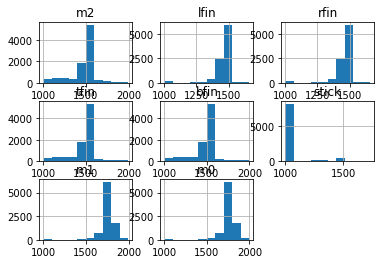

In [8]:
cur_act, cur_obs = objTrans.get_cur_transitions()
cur_act.hist()

In [9]:
objTrans.get_time()

0          40.695
1          40.750
2          40.855
3          40.950
4          41.055
           ...   
105128    617.150
105129    617.255
105130    617.350
105131    617.455
105132    617.550
Name: Time, Length: 105133, dtype: float64

array([[<AxesSubplot:title={'center':'m2'}>,
        <AxesSubplot:title={'center':'lfin'}>,
        <AxesSubplot:title={'center':'rfin'}>],
       [<AxesSubplot:title={'center':'tfin'}>,
        <AxesSubplot:title={'center':'bfin'}>,
        <AxesSubplot:title={'center':'stick'}>],
       [<AxesSubplot:title={'center':'m1'}>,
        <AxesSubplot:title={'center':'m0'}>, <AxesSubplot:>]],
      dtype=object)

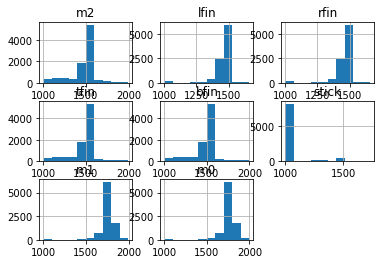

In [10]:
cur_act, cur_obs = objTrans.get_cur_transitions()
cur_act.hist()

array([[<AxesSubplot:title={'center':'linear_acceleration.x'}>,
        <AxesSubplot:title={'center':'linear_acceleration.y'}>,
        <AxesSubplot:title={'center':'linear_acceleration.z'}>,
        <AxesSubplot:title={'center':'orientation.x'}>],
       [<AxesSubplot:title={'center':'orientation.y'}>,
        <AxesSubplot:title={'center':'orientation.z'}>,
        <AxesSubplot:title={'center':'orientation.w'}>,
        <AxesSubplot:title={'center':'angVelocity.x'}>],
       [<AxesSubplot:title={'center':'angVelocity.y'}>,
        <AxesSubplot:title={'center':'angVelocity.z'}>,
        <AxesSubplot:title={'center':'velocity.linear.x'}>,
        <AxesSubplot:title={'center':'velocity.linear.y'}>],
       [<AxesSubplot:title={'center':'velocity.linear.z'}>,
        <AxesSubplot:title={'center':'target.velocity.x'}>,
        <AxesSubplot:title={'center':'target.velocity.y'}>,
        <AxesSubplot:title={'center':'target.velocity.z'}>]], dtype=object)

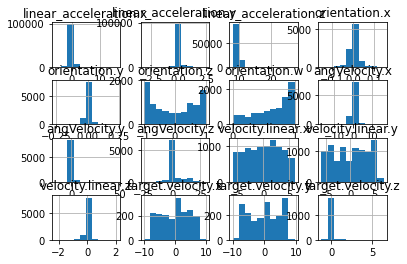

In [11]:
cur_obs.hist()

### Data processing

In [12]:
class Data_processing:
    def __init__(self):
        pass
        
    def clean_data(self, df, **params):
        df = self.fill_df_NA(df)
#         df = self.clean_time_sequence(df, round_time)
        return df
        
    def fill_df_NA(self, df):
        df = df.fillna(method='ffill')
        df = df.fillna(0)
        return df
    
    # *******************************************
    
    def clean_error_data(self, df, act_filter_feature, act_scale_bnd, **params):
        df = self.clean_act_bnd_error(df, act_scale_bnd, act_filter_feature)
        return df
    
    def clean_act_bnd_error(self, df, act_scale_bnd, act_filter_feature):
        df = self.clip_df(df, act_scale_bnd['act_min'], act_scale_bnd['act_max'], act_filter_feature)
        return df
    
    def clip_df(self, df, df_min, df_max, df_filter_feature):
        for filter_feature in df_filter_feature:
            df = df[ df[filter_feature] >= df_min ]
            df = df[ df[filter_feature] <= df_max ]
        df.reset_index(drop=True, inplace=True)
        return df
    
    # *******************************************
        
    def data_processsing(self, df, **params):
        df = self.scale_df_act(df, act_scale_bnd, act_filter_feature)
        
        if bool_addNoise:
            df = self.duplicate_Noise_df(df, num_noise_df, noise_level)
        
        if bool_round:
            df = self.round_df(df, rounding_factor)
            
        df = self.clip_scaled_df(df, act_scale_bnd, act_filter_feature)
        
        return df
    
    def scale_df_act(self, df, act_scale_bnd, act_filter_feature):
        act_max, act_min = act_scale_bnd['act_max'],  act_scale_bnd['act_min']
        scaled_act_max, scaled_act_min = act_scale_bnd['scaled_act_max'], act_scale_bnd['scaled_act_min']
        
        act = df[ act_filter_feature ]
        act = self.minmax_scale_df(act, act_max, act_min, scaled_act_max, scaled_act_min)
        df[ act_filter_feature ] = act
        return df
    
    def minmax_scale_df(self, df, df_max, df_min, target_max, target_min):
        df_mean = ( df_max + df_min) / 2 
        target_mean = ( target_max + target_min ) / 2
        
        scale = ( df_max - df_min ) / (target_max - target_min) 
        df = ( df - df_mean ) / scale + target_mean
        return df
    
    def duplicate_Noise_df(self, df, num_noise_df, noise_level):
        new_df = df
        for i in range(num_noise_df):
            noised_df = self.addNoise_df(df, noise_level)
            new_df = pd.concat([new_df, noised_df], axis=0, ignore_index=True)
                    
        return new_df
    
    def addNoise_df(self, df, noise_level):
        df_range = df.max() - df.min()
        df_noise_range = noise_level * df_range / 2
        noise = np.random.uniform(-df_noise_range, df_noise_range, df.shape)
        df = df + noise
        return df
    
    def round_df(self, df, rounding_factor):
        new_df = df.round(rounding_factor)
        return new_df
    
    def clip_scaled_df(self, df, act_scale_bnd, act_filter_feature):
        scaled_act_min, scaled_act_max = act_scale_bnd['scaled_act_min'], act_scale_bnd['scaled_act_max']
        new_df = self.clip_df(df, scaled_act_min, scaled_act_max, act_filter_feature)
        return new_df

    # *******************************************

    def split_trainTest_df(self, df, train_test_split_ratio, **params):
        df_len = len(df.index)
        idx = self.get_trainTest_index(df_len, train_test_split_ratio)
        df_train, df_test = self.split_df(df, idx)
        return df_train, df_test
        
    def split_df(self, df, idx):
        idx_train, idx_test = idx
        df_train, df_test = df.loc[idx_train], df.loc[idx_test]
        df_train=df_train.reset_index(drop=True)
        df_test=df_test.reset_index(drop=True)
        return df_train, df_test
    
    def get_trainTest_index(self, n_data, ratio):
        ratio_train, ratio_test = ratio
        n_train = int(n_data*ratio_train)
        n_test = n_data - n_train 

        idx_randperm = np.random.permutation(n_data-1)
        idx_train = np.sort(idx_randperm[:n_train])
        idx_test = np.sort(idx_randperm[n_train+1:])
        return (idx_train, idx_test)
    
    # *******************************************

    def main(self, objTrans, **params):
        df = objTrans.df
        
        print("[ Data processing ] Clean Data ")
        df = self.clean_data(df, **params)
        
        print("[ Data processing ] Clean Error Data")
        df = self.clean_error_data(df, **params)
        
        print("[ Data processing ] Scale action data, Add noise, Round data, clip data ")
        df = self.data_processsing(df, **params)

        print("[ Data processing ] Split train and test data ")
        df_train, df_test = self.split_trainTest_df(df, **params)
        
        print('[ Data processing ] Complete')
        objTrans_train, objTrans_test = objTransitions(df_train, **params), objTransitions(df_test, **params)
        
        return objTrans_train, objTrans_test
        

In [13]:
clsDataProcessing = Data_processing()
objTrans_train, objTrans_test = clsDataProcessing.main(objTrans, **params)

[ Data processing ] Clean Data 
[ Data processing ] Clean Error Data
[ Data processing ] Scale action data, Add noise, Round data, clip data 
[ Data processing ] Split train and test data 
[ Data processing ] Complete


array([[<AxesSubplot:title={'center':'m2'}>,
        <AxesSubplot:title={'center':'lfin'}>,
        <AxesSubplot:title={'center':'rfin'}>],
       [<AxesSubplot:title={'center':'tfin'}>,
        <AxesSubplot:title={'center':'bfin'}>,
        <AxesSubplot:title={'center':'stick'}>],
       [<AxesSubplot:title={'center':'m1'}>,
        <AxesSubplot:title={'center':'m0'}>, <AxesSubplot:>]],
      dtype=object)

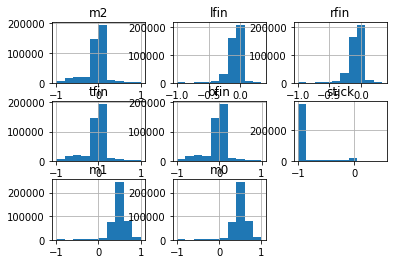

In [15]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_act.hist()

array([[<AxesSubplot:title={'center':'linear_acceleration.x'}>,
        <AxesSubplot:title={'center':'linear_acceleration.y'}>,
        <AxesSubplot:title={'center':'linear_acceleration.z'}>,
        <AxesSubplot:title={'center':'orientation.x'}>],
       [<AxesSubplot:title={'center':'orientation.y'}>,
        <AxesSubplot:title={'center':'orientation.z'}>,
        <AxesSubplot:title={'center':'orientation.w'}>,
        <AxesSubplot:title={'center':'angVelocity.x'}>],
       [<AxesSubplot:title={'center':'angVelocity.y'}>,
        <AxesSubplot:title={'center':'angVelocity.z'}>,
        <AxesSubplot:title={'center':'velocity.linear.x'}>,
        <AxesSubplot:title={'center':'velocity.linear.y'}>],
       [<AxesSubplot:title={'center':'velocity.linear.z'}>,
        <AxesSubplot:title={'center':'target.velocity.x'}>,
        <AxesSubplot:title={'center':'target.velocity.y'}>,
        <AxesSubplot:title={'center':'target.velocity.z'}>]], dtype=object)

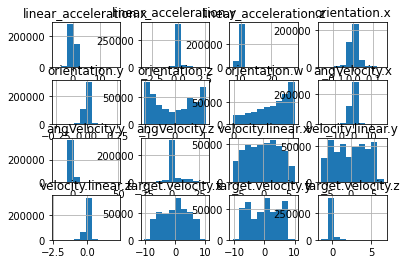

In [16]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.hist()

### Define Reward Function

In [17]:
class Define_rewardFn():
    def __init__(self):
        pass
 
    def reward_fn(self, next_obs_df, prev_act_list, prev_obs_list,
                  obs_reward_weights=(1,1), reward_weights=(1,0,1,1),
                  **params):
        
        next_obsCost_np = 0
        next_obsCost_np = self.calculate_obsCost(next_obs_df, obs_reward_weights, **params)

        prev_obsCost_np = 0
        for obs_df in prev_obs_list:
            obsCost_np = self.calculate_obsCost(obs_df, obs_reward_weights, **params)
            prev_obsCost_np += obsCost_np
        
        prev_actCost_np = 0
        for act_df in prev_act_list:
            actCost_np = self.calculate_actCost(act_df, actCost_feature_list)
            prev_actCost_np += actCost_np
        
        prev_actChangeCost_np = 0
        for i in range(len(prev_act_list)-1):
            act_df, next_act_df = prev_act_list[i], prev_act_list[i+1]
            actChangeCost_np = self.calculate_actChangeCost(act_df, next_act_df, actChangeCost_feature_list)
            prev_actChangeCost_np += actChangeCost_np

        rewards = reward_weights[0]*next_obsCost_np \
                    + reward_weights[1]*prev_obsCost_np \
                    + reward_weights[2]*prev_actCost_np \
                    + reward_weights[3]*prev_actChangeCost_np
        
        rewards = pd.DataFrame({'rewards':rewards})
        info = pd.DataFrame({'next_obsCost':next_obsCost_np, 'prev_obsCost':prev_obsCost_np, 
                             'prev_actCost':prev_actCost_np, 'prev_actChangeCost':prev_actChangeCost_np})
        return rewards, info
    
    def calculate_obsCost(self, obs_df, obs_reward_weights, **params):
        xy_target_df = obs_df[ xy_target_feature_list ]
        xy_cost_df = obs_df[ xy_cost_feature_list ]
        z_target_df = obs_df[ z_target_feature_list ]
        z_cost_df = obs_df[ z_cost_feature_list ]
        xyCost_np = obs_reward_weights[0]*self.calculate_xyCost(xy_cost_df, xy_target_df)
        zCost_np = obs_reward_weights[1]*self.calculate_zCost(z_cost_df, z_target_df)
        obs_cost_np = xyCost_np + zCost_np
        return obs_cost_np
    
    def calculate_xyCost(self, xy_df, xy_target_df):
        xyCost_np = xy_target_df.to_numpy()  - xy_df.to_numpy() 
        xyCost_np = -np.linalg.norm(xyCost_np, axis=1)
        return xyCost_np
    
    def calculate_zCost(self, z_df, z_target_df):
        zCost_np = z_target_df.to_numpy()  - z_df.to_numpy() 
        zCost_np = -np.abs(zCost_np).reshape(zCost_np.shape[0],)
        return zCost_np

    def calculate_actCost(self, act_df, actCost_feature_list):
        actCost_np = act_df[ actCost_feature_list ].to_numpy()
        actCost_np = -np.linalg.norm(actCost_np, axis=1) 
        return actCost_np
    
    def calculate_actChangeCost(self, act_df, next_act_df, actChangeCost_feature_list):
        actChangeCost_np = next_act_df[ actChangeCost_feature_list ].to_numpy() - act_df[ actChangeCost_feature_list ].to_numpy()
        actChangeCost_np = -np.linalg.norm(actChangeCost_np, axis=1) 
        return actChangeCost_np
    
    def split_xy(self, prev_act_list, prev_obs_list, next_obs, rewards):
        x_df_list = []
        for obs_df, act_df in zip(prev_obs_list, prev_act_list):
            obs_act_df = pd.concat([obs_df, act_df], axis=1)
            x_df_list.append(obs_act_df)
        x = pd.concat(x_df_list, axis=1)
        y = pd.concat([rewards, next_obs], axis=1)
        return x, y
        
    def main(self, objTrans, **params):
        prev_act_list, prev_obs_list = objTrans.get_prev_transitions_list()
        next_act, next_obs = objTrans.get_next_transitions()
                
        rewards, info = self.reward_fn(next_obs, prev_act_list, prev_obs_list, **params)
        x, y = self.split_xy(prev_act_list, prev_obs_list, next_obs, rewards)
        
        return x, y, rewards, info


In [18]:
clsDefineRewardFn = Define_rewardFn()
x_train, y_train, rewards_train, info_train = clsDefineRewardFn.main(objTrans_train, **params)
x_test, y_test, rewards_test, info_test = clsDefineRewardFn.main(objTrans_test, **params)

In [19]:
x_train

,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,angVelocity.z,...,target.velocity.y,target.velocity.z,m2,lfin,rfin,tfin,bfin,stick,m1,m0
0,0.537190,0.000111,9.867574,-0.000135,0.021726,0.002706,0.999760,0.006540,0.855038,0.045776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.541243,0.000438,9.863598,-0.000135,0.021726,0.002706,0.999760,0.006540,0.855038,0.045776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.527978,-0.000740,9.870007,-0.000135,0.021726,0.002706,0.999760,0.006540,0.855038,0.045776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.513410,-0.000298,9.877919,-0.000099,0.022935,0.002729,0.999733,0.005740,0.248852,0.041867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.496285,0.001640,9.879706,-0.000099,0.022935,0.002729,0.999733,0.005740,0.248852,0.041867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426826,-0.732908,0.166794,9.622463,0.021008,-0.007905,0.953323,0.357954,1.624293,-3.849364,0.059298,...,-0.092952,-0.019748,0.340578,-0.014561,-0.041113,0.372942,0.320257,-0.964636,0.309901,0.293250
426827,-0.864802,-0.053693,10.045363,0.023389,-0.001978,0.896725,0.365572,0.696718,-4.719330,-1.408071,...,0.373291,-0.144304,0.333429,-0.002675,-0.040374,0.352510,0.369997,-0.980563,0.363797,0.376358
426828,-0.408604,0.051733,9.757012,0.024318,-0.013249,0.980333,0.367563,0.944122,-3.666554,-1.121394,...,-0.081977,0.152377,0.400998,0.001730,-0.021812,0.304935,0.379278,-0.972146,0.383414,0.337527
426829,-0.458782,0.075379,9.529779,0.027059,-0.010009,0.899461,0.364000,1.182152,-3.719030,-1.428000,...,-0.087458,-0.001218,0.345282,-0.053335,-0.017105,0.351239,0.319737,-0.979973,0.323131,0.320683


array([[<AxesSubplot:title={'center':'next_obsCost'}>,
        <AxesSubplot:title={'center':'prev_obsCost'}>],
       [<AxesSubplot:title={'center':'prev_actCost'}>,
        <AxesSubplot:title={'center':'prev_actChangeCost'}>]],
      dtype=object)

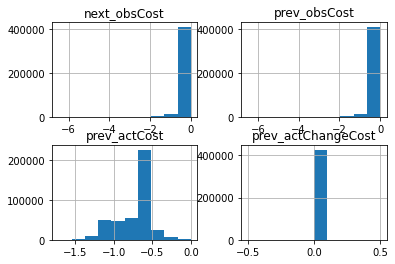

In [20]:
info_train.hist()

array([[<AxesSubplot:title={'center':'rewards'}>]], dtype=object)

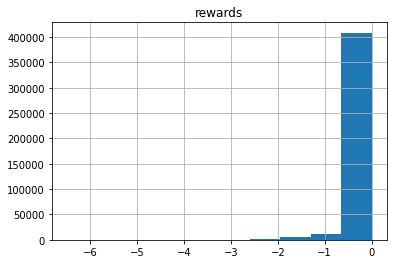

In [21]:
rewards_train.hist()

### Save data to csv

In [22]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.to_csv(os.path.join(results_path,'obs'), index=False)
cur_act.to_csv(os.path.join(results_path,'act'), index=False)
x_train.to_csv(os.path.join(results_path,'x_train'), index=False)
y_train.to_csv(os.path.join(results_path,'y_train'), index=False)
x_test.to_csv(os.path.join(results_path,'x_test'), index=False)
y_test.to_csv(os.path.join(results_path,'y_test'), index=False)

In [23]:
act_read_test = pd.read_csv(os.path.join(results_path,'act'))
obs_read_test = pd.read_csv(os.path.join(results_path,'obs'))
x_train_read_test = pd.read_csv(os.path.join(results_path,'x_train'))
y_train_read_test = pd.read_csv(os.path.join(results_path,'y_train'))

In [21]:
act_real = pd.read_csv(os.path.join(realData_path,'act'))
obs_real = pd.read_csv(os.path.join(realData_path,'obs'))
x_train_real = pd.read_csv(os.path.join(realData_path,'x_train'))
y_train_real = pd.read_csv(os.path.join(realData_path,'y_train'))
x_test_real = pd.read_csv(os.path.join(realData_path,'x_test'))
y_test_real = pd.read_csv(os.path.join(realData_path,'y_test'))

In [22]:
act_mix = pd.concat([cur_act, act_real])
obs_mix = pd.concat([cur_obs, obs_real])
x_train_mix = pd.concat([x_train, x_train_real])
y_train_mix = pd.concat([y_train, y_train_real])
x_test_mix = pd.concat([x_test, x_test_real])
y_test_mix = pd.concat([y_test, y_test_real])

In [23]:
obs_mix.to_csv(os.path.join(mix_results_path,'obs'), index=False)
act_mix.to_csv(os.path.join(mix_results_path,'act'), index=False)
x_train_mix.to_csv(os.path.join(mix_results_path,'x_train'), index=False)
y_train_mix.to_csv(os.path.join(mix_results_path,'y_train'), index=False)
x_test_mix.to_csv(os.path.join(mix_results_path,'x_test'), index=False)
y_test_mix.to_csv(os.path.join(mix_results_path,'y_test'), index=False)

<AxesSubplot:>

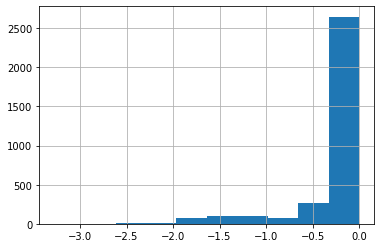

In [24]:
y_test_mix['rewards'].hist()

In [25]:
x_train_mix.columns

Index(['linear_acceleration.x', 'linear_acceleration.y',
       'linear_acceleration.z', 'orientation.x', 'orientation.y',
       'orientation.z', 'orientation.w', 'angVelocity.x', 'angVelocity.y',
       'angVelocity.z', 'velocity.linear.x', 'velocity.linear.y',
       'velocity.linear.z', 'target.velocity.x', 'target.velocity.y',
       'target.velocity.z', 'm2', 'lfin', 'rfin', 'tfin', 'bfin', 'stick',
       'm1', 'm0'],
      dtype='object')

In [26]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
objTrans_train.get_time()

0         54.455000
1         54.655000
2         54.750000
3         54.855000
4         54.950000
            ...    
132534    46.796052
132535     2.815312
132536   -27.161093
132537    33.983678
132538    41.205273
Name: Time, Length: 132539, dtype: float64

In [27]:
cur_act, cur_obs = objTrans.get_cur_transitions()
objTrans.get_time()

0           40.695
1           40.700
2           40.705
3           40.710
4           40.715
            ...   
2103535    617.575
2103536    617.580
2103537    617.585
2103538    617.590
2103539    617.595
Name: Time, Length: 2103540, dtype: float64